<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html exercisesweek37.do.txt  -->
<!-- dom:TITLE: Exercises week 37 -->

# Exercises week 37
**Implementing gradient descent for Ridge and ordinary Least Squares Regression**

Date: **September 8-12, 2025**

## Learning goals

After having completed these exercises you will have:
1. Your own code for the implementation of the simplest gradient descent approach applied to ordinary least squares (OLS) and Ridge regression

2. Be able to compare the analytical expressions for OLS and Ridge regression with the gradient descent approach

3. Explore the role of the learning rate in the gradient descent approach and the hyperparameter $\lambda$ in Ridge regression

4. Scale the data properly

## Simple one-dimensional second-order polynomial

We start with a very simple function

$$
f(x)= 2-x+5x^2,
$$

defined for $x\in [-2,2]$. You can add noise if you wish. 

We are going to fit this function with a polynomial ansatz. The easiest thing is to set up a second-order polynomial and see if you can fit the above function.
Feel free to play around with higher-order polynomials.

## Exercise 1, scale your data

Before fitting a regression model, it is good practice to normalize or
standardize the features. This ensures all features are on a
comparable scale, which is especially important when using
regularization. Here we will perform standardization, scaling each
feature to have mean 0 and standard deviation 1.

### 1a)

Compute the mean and standard deviation of each column (feature) in your design/feature matrix $\boldsymbol{X}$.
Subtract the mean and divide by the standard deviation for each feature.

We will also center the target $\boldsymbol{y}$ to mean $0$. Centering $\boldsymbol{y}$
(and each feature) means the model does not require a separate intercept
term, the data is shifted such that the intercept is effectively 0
. (In practice, one could include an intercept in the model and not
penalize it, but here we simplify by centering.)
Choose $n=100$ data points and set up $\boldsymbol{x}, $\boldsymbol{y}$ and the design matrix $\boldsymbol{X}$.

In [85]:
import numpy as np

def polynomial_features(x, p, intercept=False):
    n = len(x)
    if intercept:
        X = np.zeros((n, p + 1))
        for i in range(p + 1):
            X[:, i] = x**i
    else:
        X = np.zeros((n, p))
        for i in range(1, p + 1):
            X[:, i - 1] = x**i
    return X

In [86]:
n_features = 3
x = np.linspace(-3, 3, 100)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + np.random.normal(0, 0.1)

X = polynomial_features(x, n_features)

In [87]:
# Standardize features (zero mean, unit variance for each feature)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1  # safeguard to avoid division by zero for constant features
X_norm = (X - X_mean) / X_std

# Center the target to zero mean (optional, to simplify intercept handling)
y_mean = y.mean()
y_centered = y - y_mean

Fill in the necessary details. Do we need to center the $y$-values? 

A: We do not need to center the $y$-values. But since I am not fitting the intercept in my model, I will use the centered y-values in order to get more interpretable results.

After this preprocessing, each column of $\boldsymbol{X}_{\mathrm{norm}}$ has mean zero and standard deviation $1$
and $\boldsymbol{y}_{\mathrm{centered}}$ has mean 0. This makes the optimization landscape
nicer and ensures the regularization penalty $\lambda \sum_j
\theta_j^2$ in Ridge regression treats each coefficient fairly (since features are on the
same scale).

## Exercise 2, calculate the gradients

Find the gradients for OLS and Ridge regression using the mean-squared error as cost/loss function.

## Exercise 3, using the analytical formulae for OLS and Ridge regression to find the optimal paramters $\boldsymbol{\theta}$

Closed-form Ridge coefficients [lambda=0.1]: [ 0.78130657 -0.13815779 -0.37246822]
Closed-form OLS coefficients:                [ 0.78832838 -0.13829594 -0.37927671]


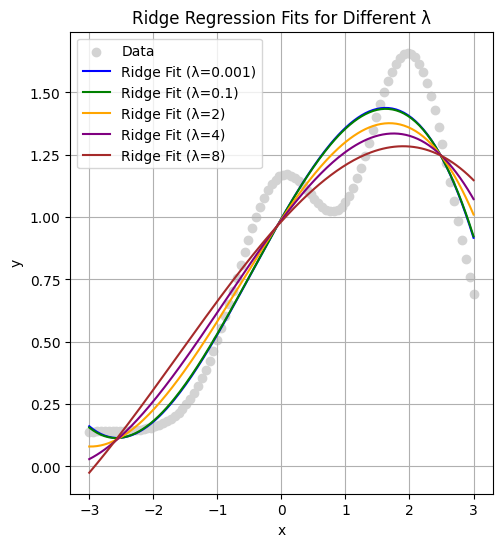

In [88]:
# Set regularization parameter, either a single value or a vector of values
# Note that lambda is a python keyword. The lambda keyword is used to create small, single-expression functions without a formal name. These are often called "anonymous functions" or "lambda functions."

lam = 0.1
# Analytical form for OLS and Ridge solution: theta_Ridge = (X^T X + lambda * I)^{-1} X^T y and theta_OLS = (X^T X)^{-1} X^T y
I = np.eye(X.shape[1])
theta_closed_formRidge = np.linalg.inv(X_norm.T @ X_norm + lam*I) @ X_norm.T @ y_centered
theta_closed_formOLS = np.linalg.inv(X_norm.T @ X_norm) @ X_norm.T @ y_centered

print(f"Closed-form Ridge coefficients [lambda={lam}]:", theta_closed_formRidge)
print("Closed-form OLS coefficients:               ", theta_closed_formOLS)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x, y, color='lightgray', label='Data')

x_fit = np.linspace(-3, 3, 200)
X_fit = polynomial_features(x_fit, 3)
X_fit_norm = (X_fit - X_mean) / X_std

lambdas = [0.001, 0.1, 2, 4, 8]
colors = ['blue', 'green', 'orange', 'purple', 'brown']

for lam, color in zip(lambdas, colors):
    theta_ridge = np.linalg.inv(X_norm.T @ X_norm + lam*I) @ X_norm.T @ y_centered
    y_fit_ridge = X_fit_norm @ theta_ridge + y_mean
    plt.plot(x_fit, y_fit_ridge, label=f'Ridge Fit (λ={lam})', color=color)

plt.title('Ridge Regression Fits for Different λ')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()

This computes the Ridge and OLS regression coefficients directly. The identity
matrix $I$ has the same size as $X^T X$. It adds $\lambda$ to the diagonal of $X^T X$ for Ridge regression. We
then invert this matrix and multiply by $X^T y$. The result
for $\boldsymbol{\theta}$  is a NumPy array of shape (n$\_$features,) containing the
fitted parameters $\boldsymbol{\theta}$.

### 3a)

Finalize, in the above code, the OLS and Ridge regression determination of the optimal parameters $\boldsymbol{\theta}$.

### 3b)

Explore the results as function of different values of the hyperparameter $\lambda$. See for example exercise 4 from week 36.

## Exercise 4, Implementing the simplest form for gradient descent

Alternatively, we can fit the ridge regression model using gradient
descent. This is useful to visualize the iterative convergence and is
necessary if $n$ and $p$ are so large that the closed-form might be
too slow or memory-intensive. We derive the gradients from the cost
functions defined above. Use the gradients of the Ridge and OLS cost functions with respect to
the parameters  $\boldsymbol{\theta}$ and set up (using the template below) your own gradient descent code for OLS and Ridge regression.

Below is a template code for gradient descent implementation of ridge:

In [89]:
def gradient_descent_ols_ridge(X_norm, y_centered, lam=0.1, eta=0.01, num_iters=10000, tol=1e-8, verbose=False):
    """
    Performs gradient descent for OLS and Ridge regression.
    Returns: theta_gdOLS, theta_gdRidge
    """
    n_features = X_norm.shape[1]
    theta = np.zeros(n_features)
    theta_gdOLS = theta.copy()
    theta_gdRidge = theta.copy()
    theta_ridge_prev = theta.copy()
    n = X_norm.shape[0]

    for t in range(num_iters):
        # Compute gradients for OLS and Ridge
        grad_OLS = 2.0/n * X_norm.T @ (X_norm @ theta_gdOLS - y_centered)
        grad_Ridge = 2.0/n * X_norm.T @ (X_norm @ theta_gdRidge - y_centered) + 2 * lam * theta_gdRidge

        # Update parameters theta
        theta_gdOLS = theta_gdOLS - eta * grad_OLS
        theta_gdRidge = theta_gdRidge - eta * grad_Ridge

        theta_diff = np.linalg.norm(theta_gdRidge - theta_ridge_prev, ord=2)
        if theta_diff < tol:
            if verbose:
                print(f"Converged after {t+1} iterations.")
            break
        theta_ridge_prev = theta_gdRidge.copy()

    return theta_gdOLS, theta_gdRidge

# Gradient descent parameters, learning rate eta first
eta = 0.001

# Regularization parameter lambda
lam = 0.01
# Then number of iterations
num_iters = 10000

# After the loop, theta contains the fitted coefficients
theta_gdOLS, theta_gdRidge = gradient_descent_ols_ridge(X_norm, y_centered, verbose=True, lam=lam, eta=eta, num_iters=num_iters)
print("Gradient Descent OLS coefficients:", theta_gdOLS)
print("Gradient Descent Ridge coefficients:", theta_gdRidge)

Gradient Descent OLS coefficients: [ 0.67827685 -0.13829594 -0.26922519]
Gradient Descent Ridge coefficients: [ 0.64432182 -0.13692668 -0.23739336]


### 4a)

Write first a gradient descent code for OLS only using the above template.
Discuss the results as function of the learning rate parameters and the number of iterations

### 4b)

Write then a similar code for Ridge regression using the above template.
Try to add a stopping parameter as function of the number iterations and the difference between the new and old $\theta$ values. How would you define a stopping criterion?

## Exercise 5, Ridge regression and a new Synthetic Dataset

We create a synthetic linear regression dataset with a sparse
underlying relationship. This means we have many features but only a
few of them actually contribute to the target. In our example, we’ll
use 10 features with only 3 non-zero weights in the true model. This
way, the target is generated as a linear combination of a few features
(with known coefficients) plus some random noise. The steps we include are:

Decide on the number of samples and features (e.g. 100 samples, 10 features).
Define the **true** coefficient vector with mostly zeros (for sparsity). For example, we set $\hat{\boldsymbol{\theta}} = [5.0, -3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]$, meaning only features 0, 1, and 6 have a real effect on y.

Then we sample feature values for $\boldsymbol{X}$ randomly (e.g. from a normal distribution). We use a normal distribution so features are roughly centered around 0.
Then we compute the target values $y$ using the linear combination $\boldsymbol{X}\hat{\boldsymbol{\theta}}$ and add some noise (to simulate measurement error or unexplained variance).

Below is the code to generate the dataset:

In [90]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define dataset size
n_samples = 100
n_features = 10

# Define true coefficients (sparse linear relationship)
theta_true = np.array([5.0, -3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0])

# Generate feature matrix X (n_samples x n_features) with random values
X = np.random.randn(n_samples, n_features)  # standard normal distribution

# Generate target values y with a linear combination of X and theta_true, plus noise
noise = 0.5 * np.random.randn(n_samples)    # Gaussian noise
y = X @ theta_true + noise

This code produces a dataset where only features 0, 1, and 6
significantly influence $\boldsymbol{y}$. The rest of the features have zero true
coefficient. For example, feature 0 has
a true weight of 5.0, feature 1 has -3.0, and feature 6 has 2.0, so
the expected relationship is:

$$
y \approx 5 \times x_0 \;-\; 3 \times x_1 \;+\; 2 \times x_6 \;+\; \text{noise}.
$$

You can remove the noise if you wish to. 

Try to fit the above data set using OLS and Ridge regression with the analytical expressions and your own gradient descent codes.

If everything worked correctly, the learned coefficients should be
close to the true values [5.0, -3.0, 0.0, …, 2.0, …] that we used to
generate the data. Keep in mind that due to regularization and noise,
the learned values will not exactly equal the true ones, but they
should be in the same ballpark.  Which method (OLS or Ridge) gives the best results?

In [91]:
# Regularization parameter lambda
lam = 0.01

# Analytical form for OLS and Ridge solution: theta_Ridge = (X^T X + lambda * I)^{-1} X^T y and theta_OLS = (X^T X)^{-1} X^T y
I = np.eye(X.shape[1])
theta_closed_formRidge = np.linalg.inv(X.T @ X + lam*I) @ X.T @ y
theta_closed_formOLS = np.linalg.inv(X.T @ X) @ X.T @ y

print(f"Closed-form Ridge coefficients:", theta_closed_formRidge)
print("Closed-form OLS coefficients:", theta_closed_formOLS)

# Gradient descent parameters, learning rate eta first
eta = 0.001
# Then number of iterations
num_iters = 10000
# After the loop, theta contains the fitted coefficients
theta_gdOLS, theta_gdRidge = gradient_descent_ols_ridge(X, y, verbose=False, tol=1e-9, lam=lam, eta=eta, num_iters=num_iters)
print("Gradient Descent OLS coefficients:", theta_gdOLS)
print("Gradient Descent Ridge coefficients:", theta_gdRidge)

# Compare estimated coefficients to true coefficients
print("\n\nTrue coefficients:", theta_true)
# difference between estimated and true coefficients
print("\nDifference (Closed-form Ridge):", np.linalg.norm(theta_closed_formRidge - theta_true))
print("Difference (Closed-form OLS):", np.linalg.norm(theta_closed_formOLS - theta_true))
print("Difference (GD Ridge):", np.linalg.norm(theta_gdRidge - theta_true))
print("Difference (GD OLS):", np.linalg.norm(theta_gdOLS - theta_true))



Closed-form Ridge coefficients: [ 4.95487593e+00 -3.02622945e+00 -1.61654169e-02  2.23708552e-02
 -6.07631056e-02  3.17328476e-02  1.89867203e+00  1.87237413e-03
  2.37702036e-02 -2.83298495e-02]
Closed-form OLS coefficients: [ 4.95551414e+00 -3.02647494e+00 -1.61933514e-02  2.23791979e-02
 -6.07172679e-02  3.16256420e-02  1.89884658e+00  1.84734523e-03
  2.36337851e-02 -2.83627205e-02]
Gradient Descent OLS coefficients: [ 4.95550542e+00 -3.02644696e+00 -1.61912822e-02  2.23529015e-02
 -6.07262096e-02  3.16450596e-02  1.89886518e+00  1.83292568e-03
  2.36703142e-02 -2.83372538e-02]
Gradient Descent Ridge coefficients: [ 4.89253636e+00 -3.00213782e+00 -1.34925344e-02  2.16005659e-02
 -6.51976953e-02  4.21090852e-02  1.88156497e+00  4.28827638e-03
  3.69585866e-02 -2.51202897e-02]


True coefficients: [ 5. -3.  0.  0.  0.  0.  2.  0.  0.  0.]

Difference (Closed-form Ridge): 0.14079608320832068
Difference (Closed-form OLS): 0.1404569725504609
Difference (GD Ridge): 0.18511553934265196
Di

In this case, OLS performed best. Specifically gradient descent performed marginally better than closed-form OLS. This is due to the underlying distribution of the data. Since the we know the distribution to be a linear expression, OLS is the right tool for this task. The reason that gradient descent permormed better than closed-form in this case is because of the added noise in the data. 

## References

[1] M. P. Deisenroth, A. A. Faisal, and C. S. Ong, *Mathematics for Machine Learning*. Cambridge University Press, 2020.  

[2] OpenAI, *ChatGPT*. Available: https://chat.openai.com/, 2025.

[3] Hastie et al (https://github.com/CompPhysics/MLErasmus/blob/master/doc/Textbooks/elementsstat.pdf)